In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import logging
from time import sleep
import os
from dotenv import load_dotenv
import psycopg2
import pickle

In [74]:
pd.set_option('display.max_rows', 50)

In [75]:
pd.set_option('display.max_columns', None)

In [76]:
load_dotenv()
logger = logging.getLogger('pro_data_extraction')

import warnings
warnings.filterwarnings('ignore')

db_name = os.getenv('POSTGRES_DB')
user = os.getenv('POSTGRES_USER')
password = os.getenv('POSTGRES_PASSWORD')
host = 'localhost'
port = '5432'

In [77]:
conn = psycopg2.connect(dbname=db_name, user=user, password=password, host=host, port=port)

In [78]:
cur = conn.cursor()

query = """
    SELECT 
        *
    FROM dota_ods.pro_matches_ml_full
    WHERE datetime >= current_date - interval '1 year'
"""

cur.execute(query)

rows = cur.fetchall()
df = pd.DataFrame(rows, columns=[desc[0] for desc in cur.description])

cur.close()
conn.close()

In [7]:
df.dropna(inplace=True)
df.head(5)

,match_data,match_id,league_id,allowed,radiant_team_id,dire_team_id,result,datetime,t1_games_last_12_months,t1_wins_last_12_months,t2_games_last_12_months,t2_wins_last_12_months,t1_games_last_3_months,t1_wins_last_3_months,t2_games_last_3_months,t2_wins_last_3_months,t1_games_last_2_weeks,t1_wins_last_2_weeks,t2_games_last_2_weeks,t2_wins_last_2_weeks,previous_games,previous_wins,team1_playerhero_kills,team1_playerhero_deaths,team1_playerhero_assists,team1_playerhero_games,team1_playerhero_winrate,team2_playerhero_kills,team2_playerhero_deaths,team2_playerhero_assists,team2_playerhero_games,team2_playerhero_winrate,team1_hero_kills,team1_hero_deaths,team1_hero_assists,team1_hero_games,team1_hero_winrate,team2_hero_kills,team2_hero_deaths,team2_hero_assists,team2_hero_games,team2_hero_winrate,team1_player_kills,team1_player_deaths,team1_player_assists,team1_player_games,team1_player_winrate,team2_player_kills,team2_player_deaths,team2_player_assists,team2_player_games,team2_player_winrate
349,"{'players': [{'account_id': 240727522, 'player...",6662225139,14286.0,False,8707099,8721429,0,2022-07-15 07:11:36,8,3,10,5,8,3,10,5,8,3,10,5,0,0,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0
350,"{'players': [{'account_id': 1190298611, 'playe...",6662225622,14105.0,False,8629318,2443375,1,2022-07-15 07:15:19,7,1,19,8,7,1,19,8,7,1,19,8,0,0,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0
351,"{'players': [{'account_id': 971762930, 'player...",6662252677,14286.0,False,8721429,8707099,0,2022-07-15 07:52:17,11,6,9,6,11,6,9,6,11,6,9,6,1,1,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,1.2,5.4,1.6,0.40000000000000000000,0.0,5.0,2.0,5.6,0.40000000000000000000,0.4,10.4,3.4,17.8,1.00000000000000000000,0.0,3.4,11.2,5.4,1.00000000000000000000,0.0
352,"{'players': [{'account_id': 301477244, 'player...",6662266328,14105.0,False,2443375,8629318,0,2022-07-15 08:15:37,20,11,8,6,20,11,8,6,20,11,8,6,1,0,0.0,0.0,0.0,0E-20,0.0,0.2,1.8,4.8,0.20000000000000000000,0.2,0.0,0.0,0.0,0E-20,0.0,5.4,9.0,14.0,1.2000000000000000,0.4,5.6,8.2,11.2,1.00000000000000000000,1.0,8.2,5.6,17.0,1.00000000000000000000,1.0
353,"{'players': [{'account_id': 1210331127, 'playe...",6662270753,14200.0,False,8546012,8750317,0,2022-07-15 08:18:54,26,15,7,5,26,15,7,5,26,15,7,5,4,3,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,6.9,5.6,11.8,0.80000000000000000000,0.2,2.9,2.9,6.9,0.60000000000000000000,0.1,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0


In [8]:
df.shape

(28166, 52)

In [9]:
df.columns

Index(['match_data', 'match_id', 'league_id', 'allowed', 'radiant_team_id',
       'dire_team_id', 'result', 'datetime', 't1_games_last_12_months',
       't1_wins_last_12_months', 't2_games_last_12_months',
       't2_wins_last_12_months', 't1_games_last_3_months',
       't1_wins_last_3_months', 't2_games_last_3_months',
       't2_wins_last_3_months', 't1_games_last_2_weeks',
       't1_wins_last_2_weeks', 't2_games_last_2_weeks', 't2_wins_last_2_weeks',
       'previous_games', 'previous_wins', 'team1_playerhero_kills',
       'team1_playerhero_deaths', 'team1_playerhero_assists',
       'team1_playerhero_games', 'team1_playerhero_winrate',
       'team2_playerhero_kills', 'team2_playerhero_deaths',
       'team2_playerhero_assists', 'team2_playerhero_games',
       'team2_playerhero_winrate', 'team1_hero_kills', 'team1_hero_deaths',
       'team1_hero_assists', 'team1_hero_games', 'team1_hero_winrate',
       'team2_hero_kills', 'team2_hero_deaths', 'team2_hero_assists',
       't

In [10]:
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day

In [11]:
df_heroes = df[['datetime', 'match_data']]

In [12]:
df_heroes['year'] = df_heroes['datetime'].dt.year
df_heroes['month'] = df_heroes['datetime'].dt.month
df_heroes['day'] = df_heroes['datetime'].dt.day

In [13]:
all_hero_ids = set(range(1, 141))
for team_number in range(2):
    for hero_id in all_hero_ids:
            column_name = f'hero_{hero_id}_team_{team_number}'
            df_heroes[column_name] = df_heroes['match_data'].apply(lambda x: 1 if any(player.get('hero_id') == hero_id \
                                    and player.get('team_number') == team_number for player in x.get('players', {})) else 0)

In [14]:
df_heroes = df_heroes.drop(columns = ['match_data', 'datetime'])

In [15]:
df_heroes['result'] = df['result']

In [16]:
with open('models/heroes_xgb_pub.pkl', 'rb') as f:
    heroes_xgb_v1 = pickle.load(f)

In [17]:
df_heroes['proba'] = heroes_xgb_v1.predict_proba(df_heroes.drop(columns=['result']).values)[:, 1]

In [18]:
df['proba'] = df_heroes['proba']

In [19]:
df['target'] = df['result']

In [21]:
df_pred = df.drop(columns = ['match_data', 'match_id', 'radiant_team_id', 'dire_team_id', 'result', 'datetime'])

In [22]:
df_pred.columns

Index(['league_id', 'allowed', 't1_games_last_12_months',
       't1_wins_last_12_months', 't2_games_last_12_months',
       't2_wins_last_12_months', 't1_games_last_3_months',
       't1_wins_last_3_months', 't2_games_last_3_months',
       't2_wins_last_3_months', 't1_games_last_2_weeks',
       't1_wins_last_2_weeks', 't2_games_last_2_weeks', 't2_wins_last_2_weeks',
       'previous_games', 'previous_wins', 'team1_playerhero_kills',
       'team1_playerhero_deaths', 'team1_playerhero_assists',
       'team1_playerhero_games', 'team1_playerhero_winrate',
       'team2_playerhero_kills', 'team2_playerhero_deaths',
       'team2_playerhero_assists', 'team2_playerhero_games',
       'team2_playerhero_winrate', 'team1_hero_kills', 'team1_hero_deaths',
       'team1_hero_assists', 'team1_hero_games', 'team1_hero_winrate',
       'team2_hero_kills', 'team2_hero_deaths', 'team2_hero_assists',
       'team2_hero_games', 'team2_hero_winrate', 'team1_player_kills',
       'team1_player_deaths'

In [24]:
df_pred = df_pred[['year', 'month', 'day', 'league_id', 'allowed', 't1_games_last_12_months',
       't1_wins_last_12_months', 't2_games_last_12_months',
       't2_wins_last_12_months', 't1_games_last_3_months',
       't1_wins_last_3_months', 't2_games_last_3_months',
       't2_wins_last_3_months', 't1_games_last_2_weeks',
       't1_wins_last_2_weeks', 't2_games_last_2_weeks', 't2_wins_last_2_weeks',
       'previous_games', 'previous_wins', 'team1_playerhero_kills',
       'team1_playerhero_deaths', 'team1_playerhero_assists',
       'team1_playerhero_games', 'team1_playerhero_winrate',
       'team2_playerhero_kills', 'team2_playerhero_deaths',
       'team2_playerhero_assists', 'team2_playerhero_games',
       'team2_playerhero_winrate', 'team1_hero_kills', 'team1_hero_deaths',
       'team1_hero_assists', 'team1_hero_games', 'team1_hero_winrate',
       'team2_hero_kills', 'team2_hero_deaths', 'team2_hero_assists',
       'team2_hero_games', 'team2_hero_winrate', 'team1_player_kills',
       'team1_player_deaths', 'team1_player_assists', 'team1_player_games',
       'team1_player_winrate', 'team2_player_kills', 'team2_player_deaths',
       'team2_player_assists', 'team2_player_games', 'team2_player_winrate', 'proba', 'target']]

In [25]:
df_pred.head(10)

,year,month,day,league_id,allowed,t1_games_last_12_months,t1_wins_last_12_months,t2_games_last_12_months,t2_wins_last_12_months,t1_games_last_3_months,t1_wins_last_3_months,t2_games_last_3_months,t2_wins_last_3_months,t1_games_last_2_weeks,t1_wins_last_2_weeks,t2_games_last_2_weeks,t2_wins_last_2_weeks,previous_games,previous_wins,team1_playerhero_kills,team1_playerhero_deaths,team1_playerhero_assists,team1_playerhero_games,team1_playerhero_winrate,team2_playerhero_kills,team2_playerhero_deaths,team2_playerhero_assists,team2_playerhero_games,team2_playerhero_winrate,team1_hero_kills,team1_hero_deaths,team1_hero_assists,team1_hero_games,team1_hero_winrate,team2_hero_kills,team2_hero_deaths,team2_hero_assists,team2_hero_games,team2_hero_winrate,team1_player_kills,team1_player_deaths,team1_player_assists,team1_player_games,team1_player_winrate,team2_player_kills,team2_player_deaths,team2_player_assists,team2_player_games,team2_player_winrate,proba,target
349,2022,7,15,14286.0,False,8,3,10,5,8,3,10,5,8,3,10,5,0,0,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,0.00,0.000000,0.000000,0E-20,0.0,0.000000,0.000000,0.000000,0E-20,0.000000,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,0.147692,0
350,2022,7,15,14105.0,False,7,1,19,8,7,1,19,8,7,1,19,8,0,0,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,0.00,0.000000,0.000000,0E-20,0.0,0.000000,0.000000,0.000000,0E-20,0.000000,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,0.435808,1
351,2022,7,15,14286.0,False,11,6,9,6,11,6,9,6,11,6,9,6,1,1,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,1.20,5.400000,1.600000,0.40000000000000000000,0.0,5.000000,2.000000,5.600000,0.40000000000000000000,0.400000,10.4,3.4,17.8,1.00000000000000000000,0.0,3.4,11.2,5.4,1.00000000000000000000,0.0,0.299755,0
352,2022,7,15,14105.0,False,20,11,8,6,20,11,8,6,20,11,8,6,1,0,0.0,0.0,0.0,0E-20,0.0,0.2,1.8,4.8,0.20000000000000000000,0.2,0.00,0.000000,0.000000,0E-20,0.0,5.400000,9.000000,14.000000,1.2000000000000000,0.400000,5.6,8.2,11.2,1.00000000000000000000,1.0,8.2,5.6,17.0,1.00000000000000000000,1.0,0.556390,0
353,2022,7,15,14200.0,False,26,15,7,5,26,15,7,5,26,15,7,5,4,3,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,6.90,5.600000,11.800000,0.80000000000000000000,0.2,2.900000,2.900000,6.900000,0.60000000000000000000,0.100000,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,0.486811,0
354,2022,7,15,14105.0,False,8,4,20,7,8,4,20,7,8,4,20,7,0,0,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,2.30,2.800000,3.300000,0.60000000000000000000,0.0,0.533333,1.933333,3.666667,0.60000000000000000000,0.066667,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,0.559137,1
355,2022,7,15,14286.0,False,13,9,2,1,13,9,2,1,13,9,2,1,0,0,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,5.40,5.800000,9.300000,1.2000000000000000,0.4,5.133333,5.533333,7.666667,1.2000000000000000,0.000000,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,0.465730,1
356,2022,7,15,14200.0,False,8,3,27,12,8,3,27,12,8,3,27,12,5,2,0.6,2.4,3.2,0.20000000000000000000,0.0,0.0,0.0,0.0,0E-20,0.0,5.75,5.700000,13.100000,2.0000000000000000,0.3,4.400000,4.600000,7.000000,1.4000000000000000,0.133333,4.6,5.4,9.8,0.80000000000000000000,0.0,7.0,6.2,14.4,1.00000000000000000000,0.0,0.279398,0
357,2022,7,15,14286.0,False,3,1,14,4,3,1,14,4,3,1,14,4,1,0,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,4.90,4.700000,6.800000,0.80000000000000000000,0.4,3.100000,4.200000,5.400000,1.00000000000000000000,0.200000,5.2,10.0,9.4,1.00000000000000000000,1.0,9.4,5.4,18.4,1.00000000000000000000,1.0,0.383480,1
358,2022,7,15,14248.0,True,2,2,0,0,2,2,0,0,2,2,0,0,0,0,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,5.50,7.166667,14.333333,1.4000000000000000,0.6,3.966667,3.250000,5.533333,1.4000000000000000,0.133333,0.0,0.0,0.0,0E-20,0.0,0.0,0.0,0.0,0E-20,0.0,0.543091,1


In [26]:
df_pred_train1 = df_pred.loc[df_pred['league_id'] != 15438].drop(columns = ['league_id', 'allowed'])

In [33]:
df_pred_test1 = df_pred.loc[df_pred['league_id'] == 15438].drop(columns = ['league_id', 'allowed'])

In [34]:
len(df_pred_train1)

28166

In [35]:
len(df_pred)

28166

In [92]:
df_pred_finale = pd.concat((df_pred_train1, df_pred_test1))

In [93]:
len(df_pred_finale)

28366

In [37]:
df_pred_train1.columns

Index(['year', 'month', 'day', 't1_games_last_12_months',
       't1_wins_last_12_months', 't2_games_last_12_months',
       't2_wins_last_12_months', 't1_games_last_3_months',
       't1_wins_last_3_months', 't2_games_last_3_months',
       't2_wins_last_3_months', 't1_games_last_2_weeks',
       't1_wins_last_2_weeks', 't2_games_last_2_weeks', 't2_wins_last_2_weeks',
       'previous_games', 'previous_wins', 'team1_playerhero_kills',
       'team1_playerhero_deaths', 'team1_playerhero_assists',
       'team1_playerhero_games', 'team1_playerhero_winrate',
       'team2_playerhero_kills', 'team2_playerhero_deaths',
       'team2_playerhero_assists', 'team2_playerhero_games',
       'team2_playerhero_winrate', 'team1_hero_kills', 'team1_hero_deaths',
       'team1_hero_assists', 'team1_hero_games', 'team1_hero_winrate',
       'team2_hero_kills', 'team2_hero_deaths', 'team2_hero_assists',
       'team2_hero_games', 'team2_hero_winrate', 'team1_player_kills',
       'team1_player_deaths'

In [94]:
X = df_pred_finale.drop(columns=['target']).values
y = df_pred_finale['target'].values

In [95]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=7)

param_grid = {
    'n_estimators': [400],
    'max_depth': [4],
    'learning_rate': [0.05],
    'gamma': [0.1],
    'reg_alpha': [0.5]
}

In [96]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

grid_search = GridSearchCV(xgb, param_grid, cv=10, scoring='roc_auc')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'gamma': [0.1], 'learning_rate': [0.05],
                         'max_depth': [4], 'n_estimators': [400],
                         'reg_alpha': [0.5]},
             scoring='roc_auc')

In [97]:
print(f"Best parameters: {grid_search.best_params_}")

y_pred = grid_search.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Best parameters: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 400, 'reg_alpha': 0.5}
Accuracy: 0.5882974973563624


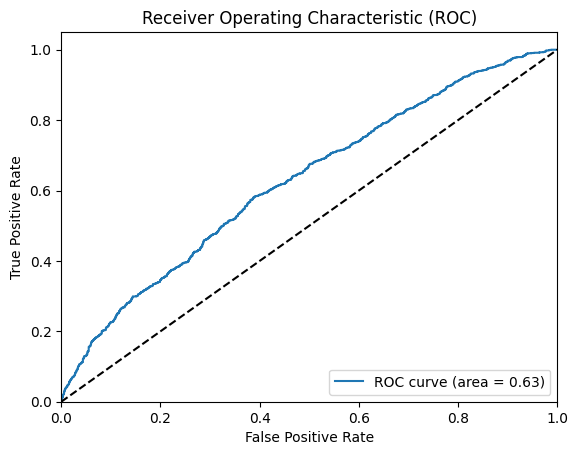

In [98]:
from sklearn.metrics import roc_curve, auc

y_score = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [99]:
grid_search.score(df_pred_test1.drop(columns = ['target']).values, df_pred_test1['target'].values)

0.9099999999999999

In [100]:
grid_search.predict_proba(df_pred_test1.drop(columns = ['target']).values).max(axis=1)

array([0.75631887, 0.5523325 , 0.57505685, 0.52239347, 0.5022798 ,
       0.55225426, 0.595042  , 0.5194561 , 0.57893   , 0.54368687,
       0.6054714 , 0.54015076, 0.7175932 , 0.63738817, 0.5390521 ,
       0.688528  , 0.57824343, 0.5691128 , 0.81891173, 0.64703697,
       0.69978523, 0.52018076, 0.6358267 , 0.5050453 , 0.61334336,
       0.5531056 , 0.678071  , 0.6267839 , 0.63923097, 0.6836871 ,
       0.67964405, 0.65679806, 0.5276292 , 0.51820934, 0.6248208 ,
       0.7588295 , 0.7527029 , 0.6207672 , 0.5127684 , 0.5002092 ,
       0.5384385 , 0.71362895, 0.57937175, 0.53282183, 0.59630436,
       0.6464259 , 0.59309834, 0.6726804 , 0.508795  , 0.587343  ,
       0.5182317 , 0.63271606, 0.58126974, 0.6860881 , 0.5244186 ,
       0.55000746, 0.56809396, 0.6447074 , 0.5290953 , 0.5273124 ,
       0.7093928 , 0.61488223, 0.6081969 , 0.54506207, 0.5422506 ,
       0.6696334 , 0.7018156 , 0.67595315, 0.5370793 , 0.6722566 ,
       0.65422827, 0.65805113, 0.667992  , 0.5324744 , 0.69463

In [45]:
df_wtf = df.loc[df['league_id'] == 15438]

In [46]:
df_wtf['predict'] = grid_search.predict(df_pred_test1.drop(columns = ['target']).values)

In [47]:
df_wtf['predict_proba'] = grid_search.predict_proba(df_pred_test1.drop(columns = ['target']).values).max(axis = 1)

In [57]:
df_wtf2 = df_wtf[['predict', 'predict_proba', 'target', 'proba', 'match_data', 'match_id', 'datetime', 'radiant_team_id', 'dire_team_id']]

In [58]:
df_wtf2.loc[df_wtf2['dire_team_id'] == 39]

,predict,predict_proba,target,proba,match_data,match_id,datetime,radiant_team_id,dire_team_id
27385,1,0.659547,1,0.789932,"{'players': [{'account_id': 54580962, 'player_...",7220296489,2023-06-29 05:03:47,2163,39
27485,1,0.504314,1,0.393747,"{'players': [{'account_id': 10366616, 'player_...",7221630397,2023-06-30 05:04:56,8291895,39
27508,0,0.523186,1,0.543045,"{'players': [{'account_id': 94281932, 'player_...",7221782037,2023-06-30 09:20:25,8668460,39
27578,0,0.718210,0,0.428824,"{'players': [{'account_id': 156029808, 'player...",7222989370,2023-07-01 05:00:06,8254145,39
27585,0,0.683348,1,0.578647,"{'players': [{'account_id': 156029808, 'player...",7223052578,2023-07-01 06:29:40,8254145,39
27609,0,0.568625,1,0.493953,"{'players': [{'account_id': 148215639, 'player...",7223229523,2023-07-01 10:12:53,6209166,39
27621,1,0.561272,1,0.761705,"{'players': [{'account_id': 148215639, 'player...",7223318461,2023-07-01 11:42:27,6209166,39
27688,0,0.577109,1,0.644135,"{'players': [{'account_id': 321580662, 'player...",7224537050,2023-07-02 06:21:27,7119388,39
27709,0,0.646244,0,0.498979,"{'players': [{'account_id': 202217968, 'player...",7224738368,2023-07-02 10:22:19,5,39
27806,1,0.548952,1,0.726290,"{'players': [{'account_id': 94281932, 'player_...",7226256930,2023-07-03 11:53:58,8668460,39


In [59]:
y

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

In [60]:
df_wtf2.loc[df_wtf2['predict'] != df_wtf2['target']]

,predict,predict_proba,target,proba,match_data,match_id,datetime,radiant_team_id,dire_team_id
27389,0,0.510153,1,0.456749,"{'players': [{'account_id': 86745912, 'player_...",7220336186,2023-06-29 06:06:20,39,2163
27392,0,0.517481,1,0.543191,"{'players': [{'account_id': 148215639, 'player...",7220352802,2023-06-29 06:35:10,6209166,7119388
27396,1,0.581278,0,0.314528,"{'players': [{'account_id': 87063175, 'player_...",7220380359,2023-06-29 07:25:01,8728920,15
27405,0,0.510332,1,0.504461,"{'players': [{'account_id': 87063175, 'player_...",7220422250,2023-06-29 08:31:57,8728920,15
27411,1,0.500718,0,0.485961,"{'players': [{'account_id': 94281932, 'player_...",7220453964,2023-06-29 09:20:48,8668460,2163
...,...,...,...,...,...,...,...,...,...
28117,1,0.541579,0,0.442441,"{'players': [{'account_id': 54580962, 'player_...",7231514394,2023-07-07 14:21:48,2163,8291895
28167,1,0.521870,0,0.640577,"{'players': [{'account_id': 100058342, 'player...",7232833846,2023-07-08 12:17:47,8291895,8599101
28171,1,0.634959,0,0.721058,"{'players': [{'account_id': 183719386, 'player...",7232914458,2023-07-08 13:47:06,8894818,2163
28255,0,0.502649,1,0.451346,"{'players': [{'account_id': 91730177, 'player_...",7234512983,2023-07-09 14:18:52,8599101,2163


In [61]:
df_wtf2.sort_values(by='datetime')

,predict,predict_proba,target,proba,match_data,match_id,datetime,radiant_team_id,dire_team_id
27386,1,0.587266,1,0.460042,"{'players': [{'account_id': 10366616, 'player_...",7220296983,2023-06-29 05:01:26,8291895,8254400
27387,0,0.609085,0,0.616582,"{'players': [{'account_id': 156029808, 'player...",7220299602,2023-06-29 05:01:42,8254145,5
27385,1,0.659547,1,0.789932,"{'players': [{'account_id': 54580962, 'player_...",7220296489,2023-06-29 05:03:47,2163,39
27388,0,0.508261,0,0.672943,"{'players': [{'account_id': 148215639, 'player...",7220315256,2023-06-29 05:22:10,6209166,7119388
27389,0,0.510153,1,0.456749,"{'players': [{'account_id': 86745912, 'player_...",7220336186,2023-06-29 06:06:20,39,2163
...,...,...,...,...,...,...,...,...,...
28238,0,0.513782,0,0.613343,"{'players': [{'account_id': 10366616, 'player_...",7234063473,2023-07-09 07:10:22,8291895,2163
28247,1,0.592222,1,0.411354,"{'players': [{'account_id': 91730177, 'player_...",7234263112,2023-07-09 11:00:06,8599101,2163
28251,1,0.670318,1,0.591216,"{'players': [{'account_id': 73562326, 'player_...",7234394896,2023-07-09 12:54:30,2163,8599101
28255,0,0.502649,1,0.451346,"{'players': [{'account_id': 91730177, 'player_...",7234512983,2023-07-09 14:18:52,8599101,2163


In [62]:
best_model = grid_search.best_estimator_

importances = best_model.feature_importances_

feature_names = df_pred_train1.drop('target', axis=1).columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

importance_df = importance_df.sort_values('Importance', ascending=False)

print(importance_df)

                     Feature  Importance
43       team2_player_deaths    0.050005
38       team1_player_deaths    0.046860
15            previous_games    0.037282
16             previous_wins    0.029895
42        team2_player_kills    0.029148
24  team2_playerhero_assists    0.028740
40        team1_player_games    0.027263
39      team1_player_assists    0.026974
4     t1_wins_last_12_months    0.026356
19  team1_playerhero_assists    0.024683
37        team1_player_kills    0.024007
47                     proba    0.023681
8      t1_wins_last_3_months    0.023668
45        team2_player_games    0.023350
44      team2_player_assists    0.023083
12      t1_wins_last_2_weeks    0.022633
25    team2_playerhero_games    0.022375
7     t1_games_last_3_months    0.020376
13     t2_games_last_2_weeks    0.019537
20    team1_playerhero_games    0.019333
22    team2_playerhero_kills    0.019258
17    team1_playerhero_kills    0.019090
3    t1_games_last_12_months    0.018911
14      t2_wins_

In [63]:
grid_search.score(X_test, y_test)

0.623673782565459

In [101]:
with open("models/teams_modelv2.pkl", "wb") as file: 
    pickle.dump(grid_search, file)

In [82]:
import openpyxl
df_wtf2.to_excel('data/bali.xlsx', index = False)